<a href="https://colab.research.google.com/github/tima2015/SUSU-MNT-Lab1/blob/main/Backpropagation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Подготовка данных

## Основные используемые библиотеки

In [ ]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from google.colab import output as outputCollab
%matplotlib inline

## Импортируем образцов рукописного написания цифр

In [ ]:
from keras.datasets import mnist
(trainX, trainY), (testX, testY) = mnist.load_data()
w = trainX.shape[1]
h = trainX.shape[2]
resolution = w*h

## Определяем метод нормализации

In [ ]:
def normalize(x, min, max):
  return (x-min)/(max-min)

## Инициализируем OneHotEncoder

In [ ]:
ohe = OneHotEncoder()

## Подгоняем данные

In [ ]:
trainY = trainY.reshape(-1, 1)
ohe.fit(trainY)
transformed_train = ohe.transform(trainY).toarray()
trainX_2 = np.zeros((trainX.shape[0],resolution))
for i in range(trainX.shape[0]):
  trainX_2[i] = normalize(trainX[i].flatten(),0,255)

testY = testY.reshape(-1, 1)
ohe.fit(testY)
transformed_test = ohe.transform(testY).toarray()
testX_2 = np.zeros((testX.shape[0],resolution))
for i in range(testX.shape[0]):
  testX_2[i] = normalize(testX[i].flatten(),0,255)

и выведем подготовленные данные

y_train = [[7]]
y_test = [[6]]
--------------------
transformed_train = [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
transformed_test = [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
--------------------
X_train2.shape = [(60000, 784)]
X_test2.shape = [(10000, 784)]


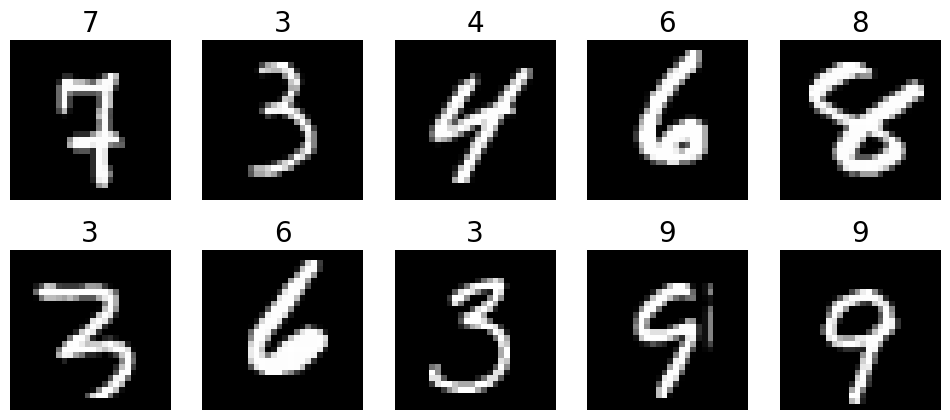

In [ ]:
print(f'y_train = [{trainY[123]}]')
print(f'y_test = [{testY[123]}]')
print('--------------------')
print(f'transformed_train = [{transformed_train[123]}]')
print(f'transformed_test = [{transformed_test[123]}]')
print('--------------------')
print(f'X_train2.shape = [{trainX_2.shape}]')
print(f'X_test2.shape = [{testX_2.shape}]')

fig, axes = plt.subplots(2,5, figsize=(12,5))
axes = axes.flatten()
idx = np.random.randint(0,60000,size=10)
for i in range(10):
    axes[i].imshow(trainX[idx[i],:].reshape(28,28), cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(str(int(trainY[idx[i]])), color= 'black', fontsize=20)
plt.show()

# Метод обратного распространения ошибки

Метод обратного распространения ошибки разрабатывается, исходя из следующих предположений: 
1. На входе сети имеется 𝑤×ℎ (resolution) нейронов, что соответствует разрешению изображения. 
2. На выходе сети имеется 𝑘 нейронов, что соответствует количеству классов изображений. 
3. Скрытый слой содержит 𝑠 нейронов. 
4. В качестве функции активации на втором слое используется функция softmax. 


## Функция активации

In [ ]:
def softmax(x):
  return np.exp(x) / np.sum(np.exp(x), axis=1).reshape(-1,1)

## Сеть 

In [ ]:
class BackPropNeuralNetwork:
  # resolution - разрешение изображения
  # k - количество нейронов на выходе сети
  # s - количество нейронов скрытого слоя
  # activationFunc - функция активации
  def __init__(self, resolution, k, s, activationFunc):
    self.resolution = resolution
    self.k = k
    self.s = s
    self.activationFunc = activationFunc
    self.__init_weights()
    
  #Инициализация весов
  def __init_weights(self):
    self.hidden_layer_weights = np.random.rand(self.resolution, self.s) * 0.1
    self.output_layer_weights = np.random.rand(self.s, self.k) * 0.1
    self.bias = np.random.randn(self.s) * 0.1

  def __calc_hide_layer_output(self, x):
    hide_layer_output = np.matmul(x, self.hidden_layer_weights) + self.bias
    hide_layer_output[hide_layer_output < 0] = 0
    return hide_layer_output

  def __calc_hide_layer_derivative(self, hide_layer_output):
    hide_layer_output[hide_layer_output > 0] = 1
    return hide_layer_output

  #Прямой проход:
  #   1. Вычисление значений выходных сигналов нейронов всех слоев
  #   2. Вычисление значений производных функций активации на каждом слое сети
  def __forward(self, x):
    #выход скрытого слоя
    hide_layer_output = self.__calc_hide_layer_output(x)
    #производная выхода скрытого слоя
    derivative = self.__calc_hide_layer_derivative(hide_layer_output)
    #выход сети
    output = self.activationFunc(np.matmul(hide_layer_output, self.output_layer_weights))
    return output, hide_layer_output, derivative

  #Обратный проход:
  #   1. Вычисление значения целевой функции и ее градиента
  #   2. Корректировка синаптических весов
  def __reverse(self, trainX, trainY, currentOutput, current_hide_layer_output, derivative, alpha):
    error = currentOutput - trainY
    grad_output = np.matmul(current_hide_layer_output.T, error)
    
    error_hide_layer = np.matmul(error, self.output_layer_weights.T)*derivative
    grad_hide_layer = np.matmul(trainX.T, error_hide_layer)
    
    delta_output = grad_output / self.resolution + alpha * self.output_layer_weights
    delta_hidden = grad_hide_layer / self.resolution + alpha * self.hidden_layer_weights
    delta_bias = np.mean(error_hide_layer, axis=0)

    return delta_output, delta_hidden, delta_bias

  #Обработать входные данные
  def handleInput(self, x):
    result,_,_ = self.__forward(x)
    return result

  def train(self, trainX, trainY, stepCount = 1500, lr = 0.1, alpha = 1e-6, acceptableError = 0.005):
    self.__init_weights()
    error_history = []
    for i in range(stepCount):
      output, hide_layer_output, derivative = self.__forward(trainX)
      error = np.mean(np.abs(output - trainY))
      outputCollab.clear()
      print(f'iteration: {i}/{stepCount}')
      print(f'current error: {error}')
      error_history.append(error)
      if (error <= acceptableError):
        break
      delta_output, delta_hidden, delta_bias = self.__reverse(trainX, trainY, output, hide_layer_output, derivative, alpha)
      #self.hidden_layer_weights -= lr*delta_hidden
      #self.output_layer_weights -= lr*delta_output
      #self.bias -= lr*delta_bias

      #RMSProp
      gamma = 0.99
      eps = 1e-3
      eta = 5e-1
      ghidden = goutput = gb = 1
      ghidden = gamma*ghidden + (1-gamma)*np.sum(delta_hidden**2)
      eta_hidden = eta/np.sqrt(ghidden + eps)
      self.hidden_layer_weights -= eta_hidden * delta_hidden
      goutput = gamma*goutput + (1-gamma)*np.sum(delta_output**2)
      eta_output = eta/np.sqrt(goutput + eps)
      self.output_layer_weights -= eta_output * delta_output
      gb = gamma*gb + (1-gamma)*np.sum(delta_bias**2)
      etab = eta/np.sqrt(gb + eps)
      self.bias -= etab * delta_bias

      randomize = np.arange(trainX.shape[0])
      np.random.shuffle(randomize)
      trainX = trainX[randomize]
      trainY = trainY[randomize]
    return error_history

      


# Работа с сетью
## Инициализация сети

In [ ]:
s = 300
k = 10
net = BackPropNeuralNetwork(resolution, k, s, softmax)

## Обучение сети

In [ ]:
%%time
error_history = net.train(trainX_2, transformed_train)

iteration: 1499/1500
current error: 0.01196946631164383
CPU times: user 1h 36min 7s, sys: 13min 38s, total: 1h 49min 46s
Wall time: 1h 2min 11s


# Результаты обучения

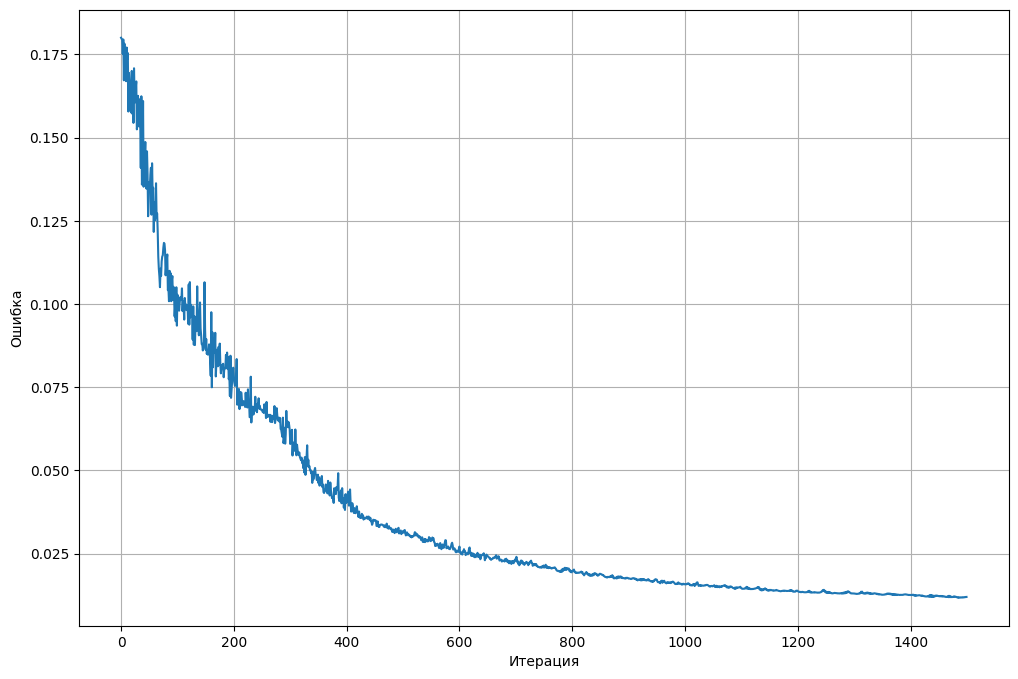

In [ ]:
# Изобразим график ошибки 
plt.figure(figsize=(12,8))
x = list(range(len(error_history)))
plt.plot(x, error_history)
plt.xlabel('Итерация')
plt.ylabel('Ошибка')
plt.grid()

In [ ]:
# Предскажем выход для тестовых данных
y_pred_test = net.handleInput(testX_2)
count = 0
for j in range(len(transformed_test)):
  if np.argmax(y_pred_test[j]) == np.argmax(transformed_test[j]):
    count+=1
print('Test error:',(1-count/len(testX_2))*100)

Test error: 5.200000000000005


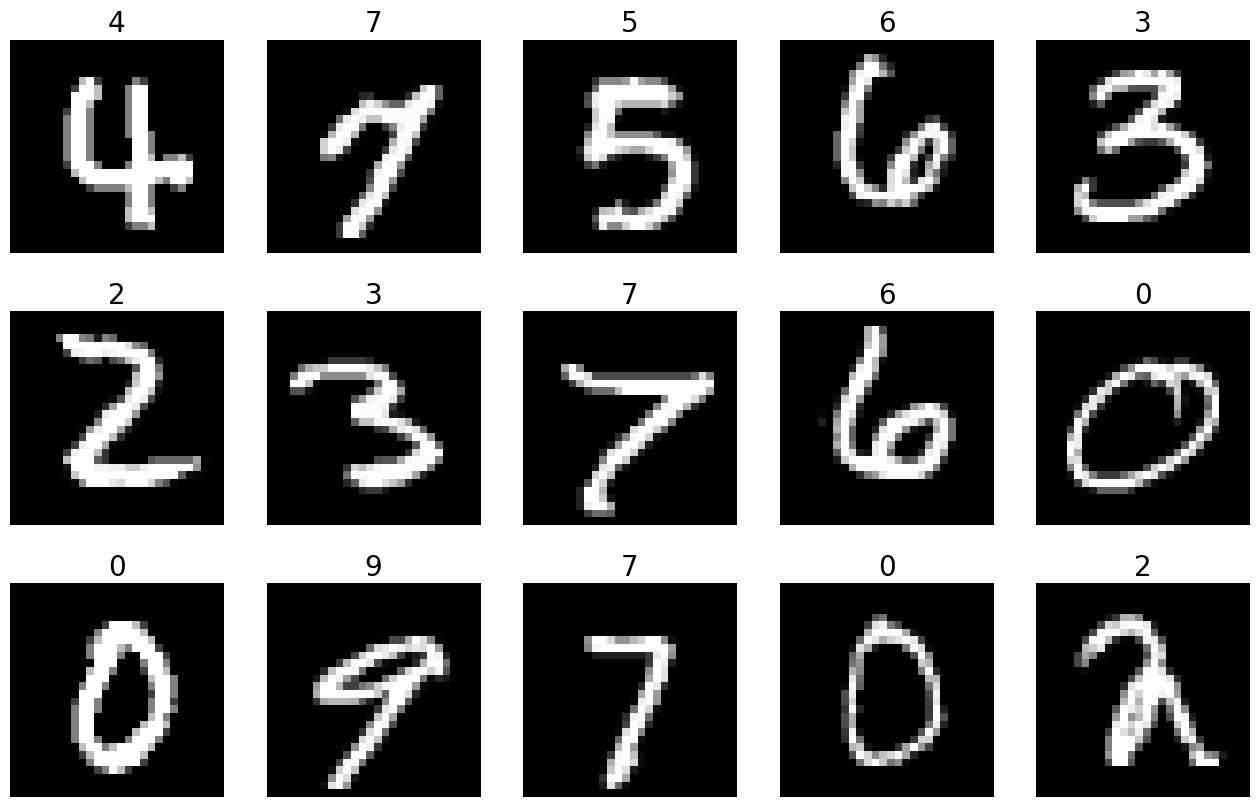

In [ ]:
fig, axes = plt.subplots(3,5, figsize=(16,10))
axes = axes.flatten()
idx = np.random.randint(0,10000,size=15)
for i in range(15):
    axes[i].imshow(testX_2[idx[i],:].reshape(28,28), cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(str(int(np.argmax(y_pred_test[idx[i]]))), color= 'black', fontsize=20)
plt.show()

# Памятка (для себя)

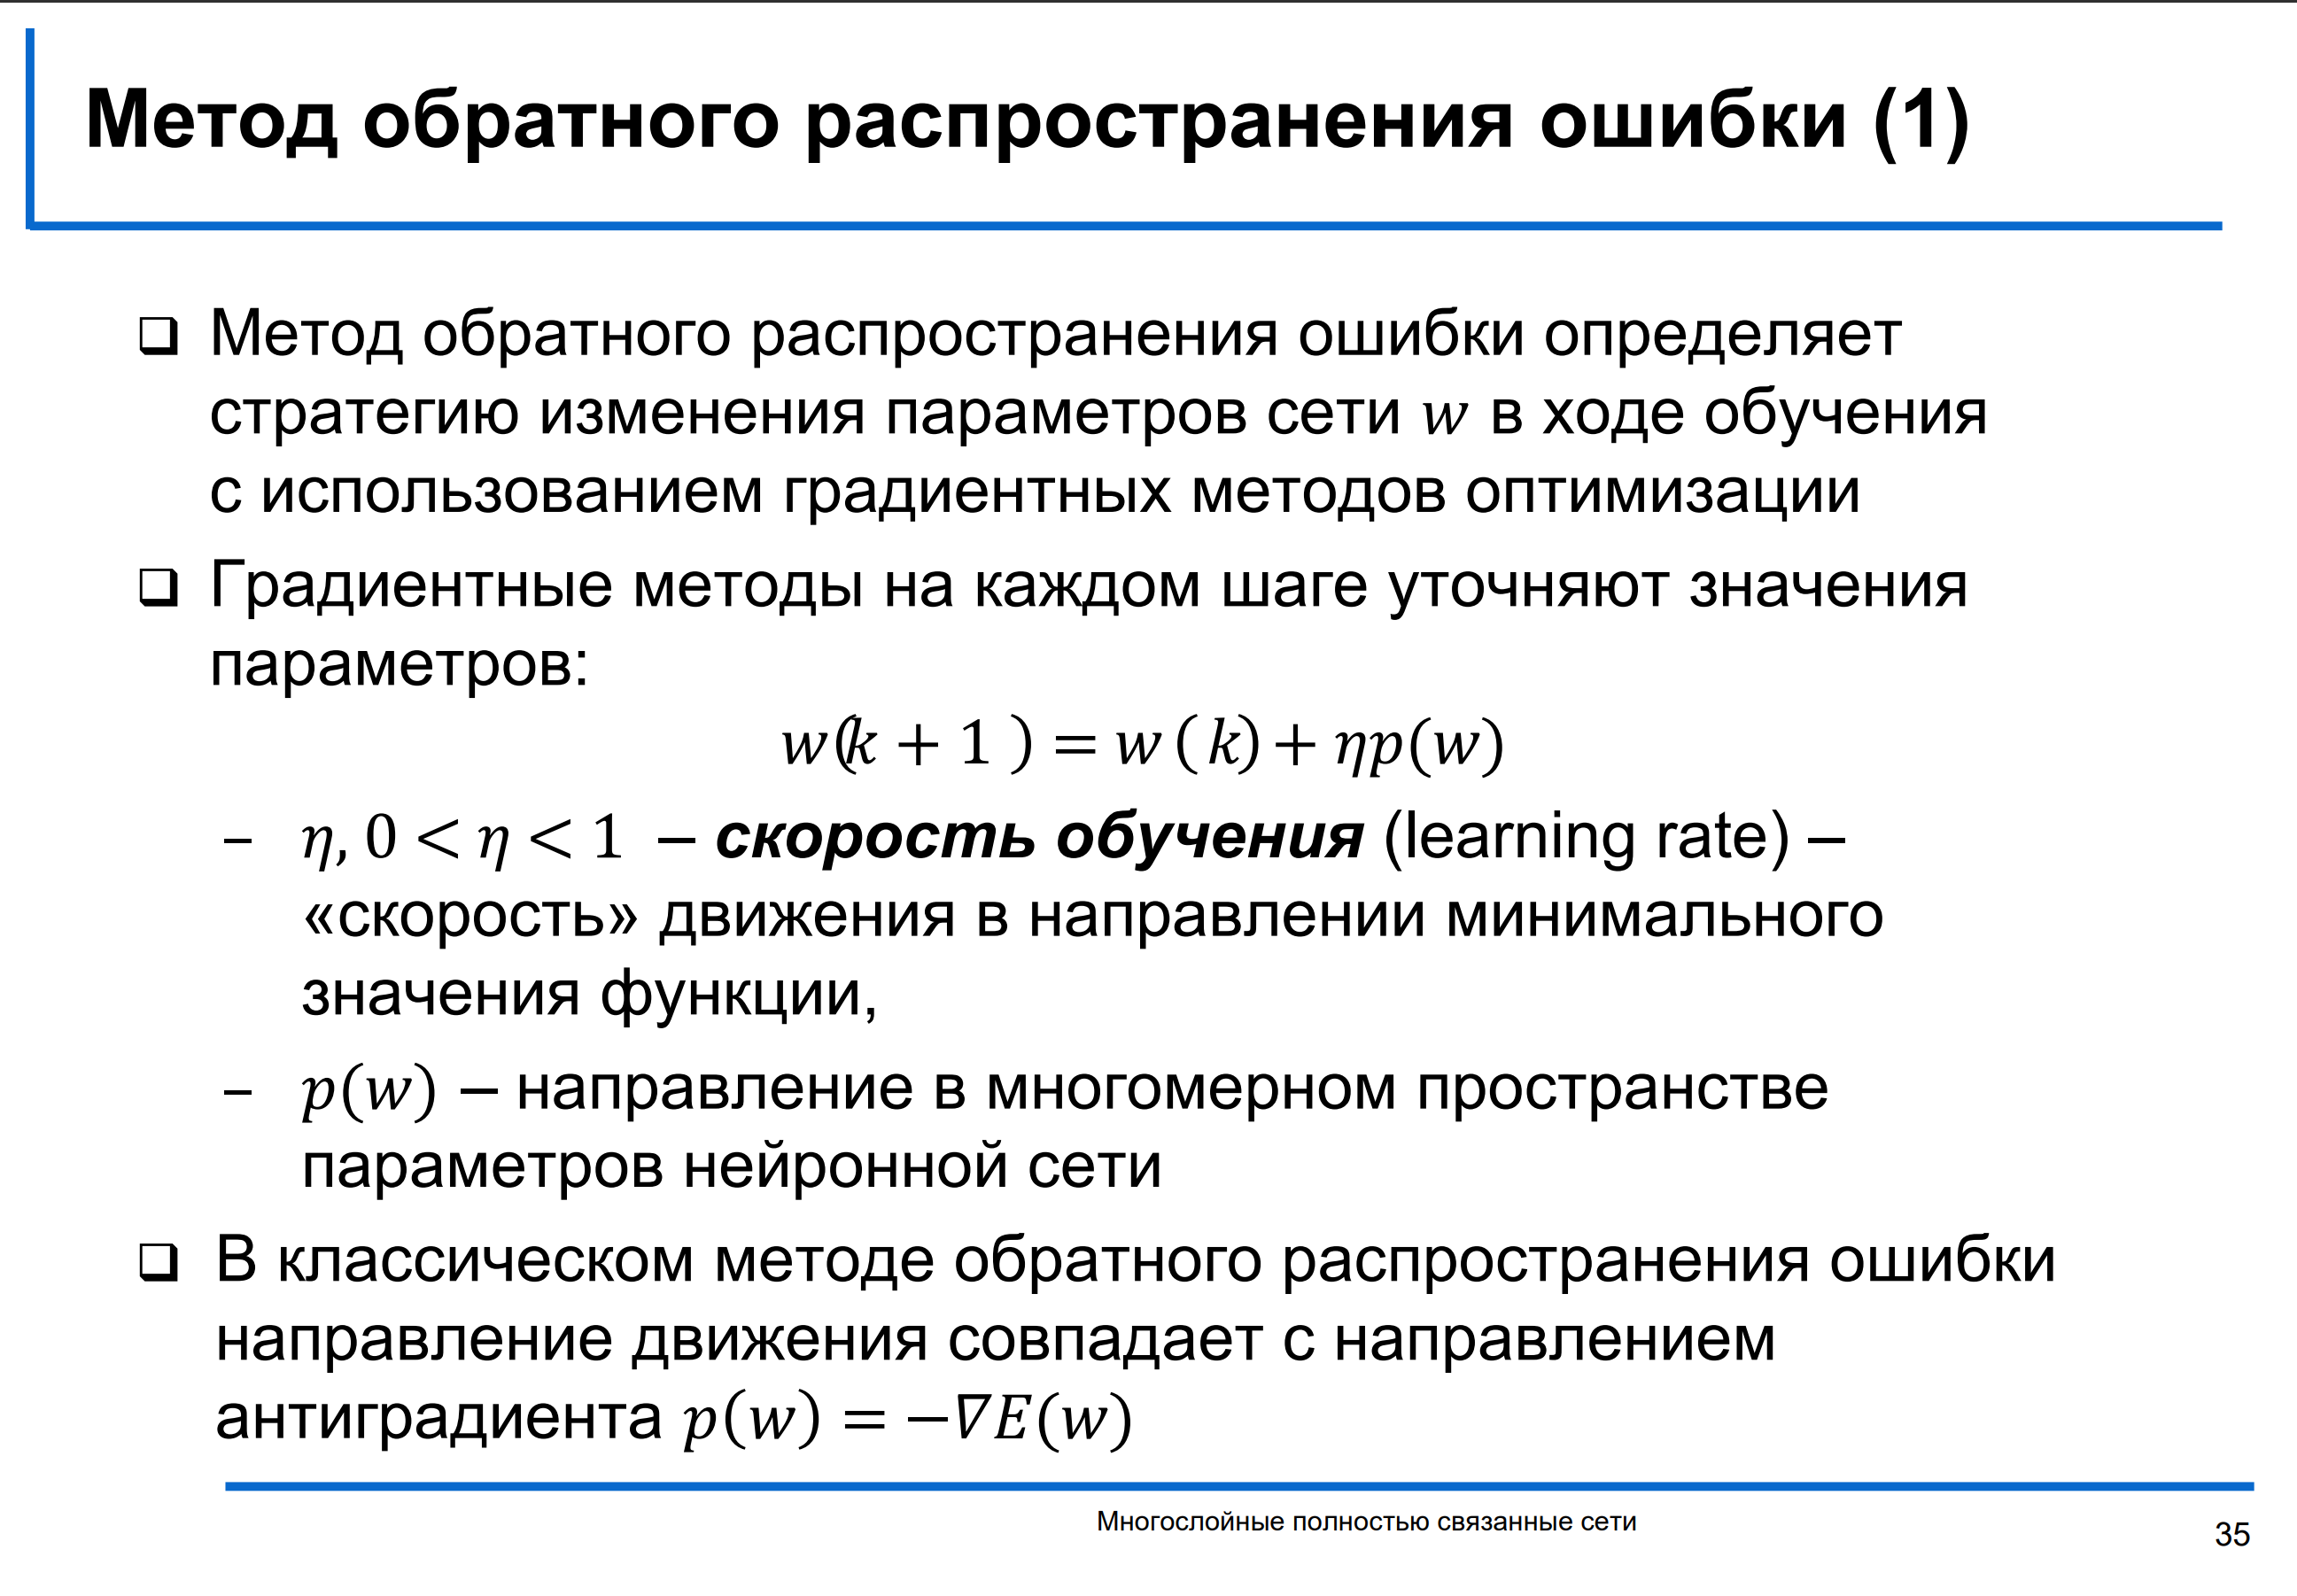